(f_rs_crs)=


----------------

```{admonition} Learning Objectives
- Reproject remotely sensed data (change CRS)
- Reproject on-the-fly
- Understand resampling options
```
```{admonition} Review
* [What is a CRS](d_crs_what_is_it.md)
* [Understanding CRS codes](d_understand_crs_codes.md)
* [Raster CRS](d_raster_crs_intro.md)
```
----------------


# Remote Sensing Coordinate Reference Systems

Image projections can be transformed in GeoWombat using the configuration manager (see [Config Manager](f_rs_config.md)). With the configuration manager, the CRS is transformed using [rasterio CRS](https://rasterio.readthedocs.io/en/latest/api/rasterio.crs.html) and [virtual warping](https://rasterio.readthedocs.io/en/latest/topics/virtual-warping.html). For references, see [Spatial Reference](https://spatialreference.org/) and [epsg.io](http://epsg.io/).

## View Image Coordinate Reference System & Properties
In the following we will print out the properties relevant to CRS for the red, green blue image. The CRS can be accessed from the [xarray.DataArray](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html) attributes.

In [1]:
import geowombat as gw
from geowombat.data import rgbn

with gw.open(rgbn) as src:
    print(src.transform)
    print(src.gw.transform)
    print(src.crs)
    print(src.resampling)
    print(src.res)
    print(src.gw.cellx, src.gw.celly)

(5.0, 0.0, 792988.0, 0.0, -5.0, 2050382.0)
(5.0, 0.0, 792988.0, 0.0, -5.0, 2050382.0)
+init=epsg:32618
nearest
(5.0, 5.0)
5.0 5.0


## Transforming a CRS On-The-Fly

To transform the CRS, use the context manager. In this example, an proj4 code is used. See [understanding CRS codes](d_understand_crs_codes.md) for more details.

(5.0, 0.0, 2502400.7632678417, 0.0, -5.0, -2147313.7330151177)
+proj=aea +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs=True
nearest
(5.0, 5.0)


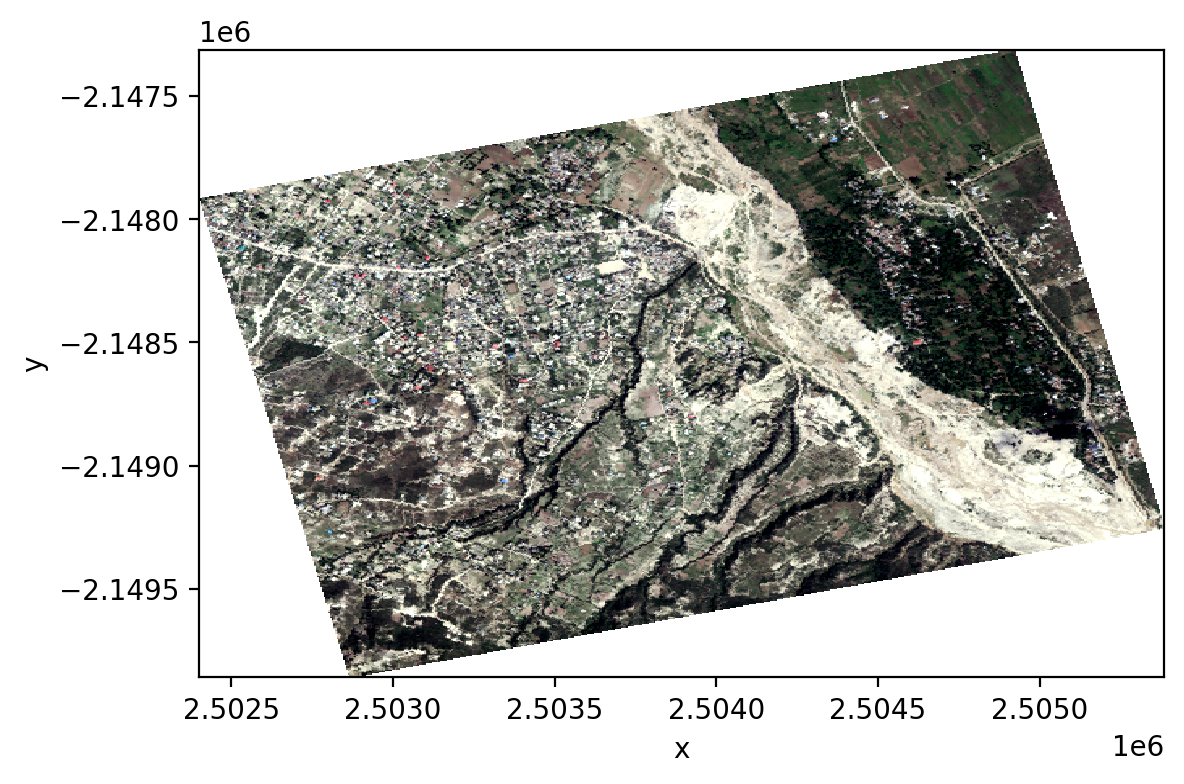

In [2]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=200)

proj4 = "+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"

with gw.config.update(ref_crs=proj4):
    with gw.open(rgbn) as src:
        print(src.transform)
        print(src.crs)
        print(src.resampling)
        print(src.res)
        src.where(src != 0).sel(band=[3,2,1]).plot.imshow(robust=True, ax=ax)

plt.tight_layout(pad=1)

Other formats supported by rasterio, (e.g., PROJ4 strings) can be used.

In [3]:
with gw.config.update(ref_crs=proj4):
    with gw.open(rgbn) as src:
        print(src.transform)
        print(src.crs)
        print(src.resampling)
        print(src.res)

(5.0, 0.0, 2502400.7632678417, 0.0, -5.0, -2147313.7330151177)
+proj=aea +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs=True
nearest
(5.0, 5.0)


## Resampling the Cell Size

The resampling algorithm can be specified in the `geowombat.open` function. Here, we use cubic convolution resampling to warp the data to EPSG code 31972 (a UTM projection).

In [4]:
with gw.config.update(ref_crs=31972):
    with gw.open(rgbn, resampling='cubic') as src:
        print(src.transform)
        print(src.crs)
        print(src.resampling)
        print(src.res)

(5.0, 0.0, 792988.0000004865, 0.0, -5.0, 2050381.9999358936)
+init=epsg:31972
cubic
(5.0, 5.0)


The transformed cell resolution can be added in the context manager. Here, we resample the data to 10m x 10m spatial resolution.

In [5]:
with gw.config.update(ref_crs=31972, ref_res=(10, 10)):
    with gw.open(rgbn, resampling='cubic') as src:
        print(src.transform)
        print(src.crs)
        print(src.resampling)
        print(src.res)

(10.0, 0.0, 792988.0000004865, 0.0, -10.0, 2050381.9999358936)
+init=epsg:31972
cubic
(10.0, 10.0)


## Transformations Outside Context Manager

To transform an `xarray.DataArray` outside of a configuration context, use the `geowombat.transform_crs` function.

In [6]:
with gw.open(rgbn) as src:
    print(src.transform)
    print(src.crs)
    print(src.resampling)
    print(src.res)
    print('')
    src_tr = src.gw.transform_crs(proj4, dst_res=(10, 10), resampling='bilinear')
    print(src_tr.transform)
    print(src_tr.crs)
    print(src_tr.resampling)
    print(src_tr.res)

(5.0, 0.0, 792988.0, 0.0, -5.0, 2050382.0)
+init=epsg:32618
nearest
(5.0, 5.0)



(10.0, 0.0, 2502400.7632678417, 0.0, -10.0, -2147313.7330151177)
PROJCS["unknown",GEOGCS["unknown",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",20],PARAMETER["standard_parallel_2",60],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
bilinear
(10, 10)


For more help we can read through the docs a bit.

In [7]:
with gw.open(rgbn, resampling='cubic') as src:
    print(help(src.gw.transform_crs))

Help on method transform_crs in module geowombat.core.geoxarray:

transform_crs(dst_crs=None, dst_res=None, dst_width=None, dst_height=None, dst_bounds=None, coords_only=False, resampling='nearest', warp_mem_limit=512, num_threads=1) method of geowombat.core.geoxarray.GeoWombatAccessor instance
    Transforms a DataArray to a new coordinate reference system
    
    Args:
        dst_crs (Optional[CRS | int | dict | str]): The destination CRS.
        dst_res (Optional[tuple]): The destination resolution.
        dst_width (Optional[int]): The destination width. Cannot be used with ``dst_res``.
        dst_height (Optional[int]): The destination height. Cannot be used with ``dst_res``.
        dst_bounds (Optional[BoundingBox | tuple]): The destination bounds, as a ``rasterio.coords.BoundingBox``
            or as a tuple of (left, bottom, right, top).
        coords_only (Optional[bool]): Whether to return transformed coordinates. If ``coords_only`` = ``True`` then
            the arr